# TurnUpVisualization

## Imports 

In [25]:
import numpy as np
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc

## Data Cleanup

In [26]:
# Input data from csv
data = pds.read_csv('No-show-Issue-Comma-300k-corrected.csv')

# Turn gender inot a binary value (Male is 1 and female is 0)
data.Gender = data.Gender.apply(lambda x: 1 if x == 'M' else 0)

# Turn day of the week into a number
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.DayOfTheWeek = data.DayOfTheWeek.apply(lambda x: days.index(x))

Accuracy:  59.4 %
Sending an sms to the top 10% has a change of -0.002933164728060655 in probability of showing up
AUC:  0.581855660834


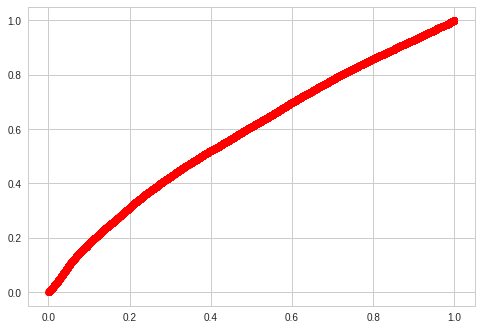

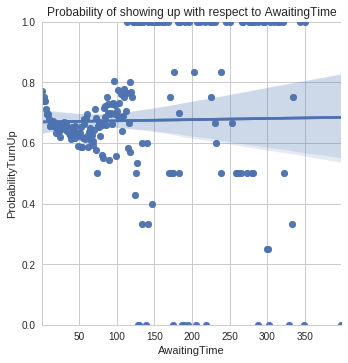

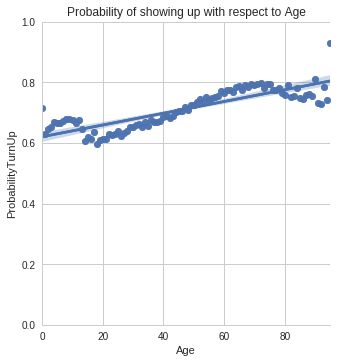

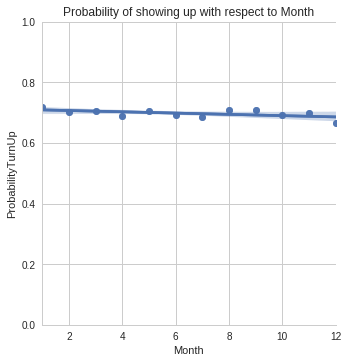

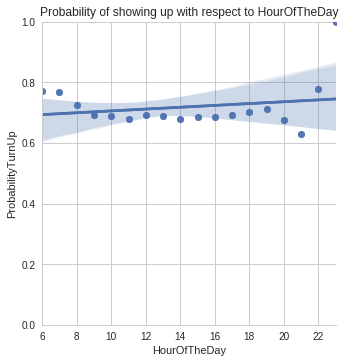

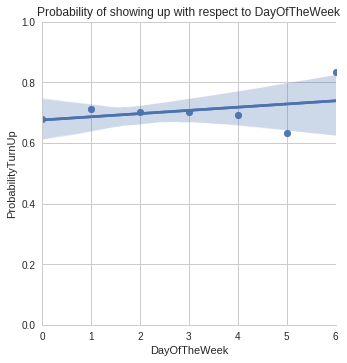

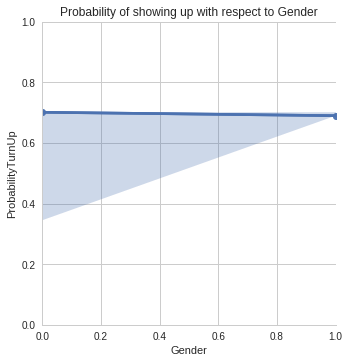

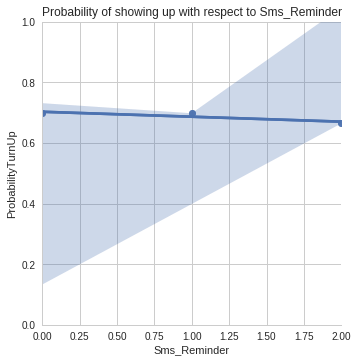

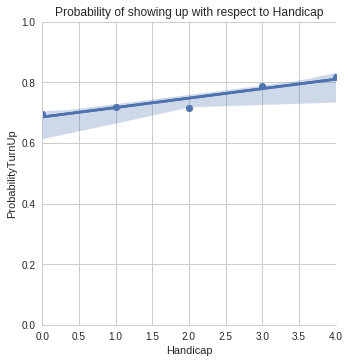

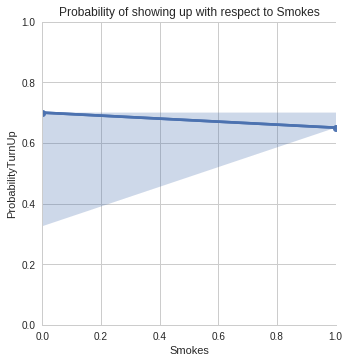

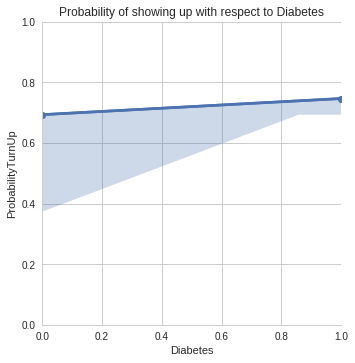

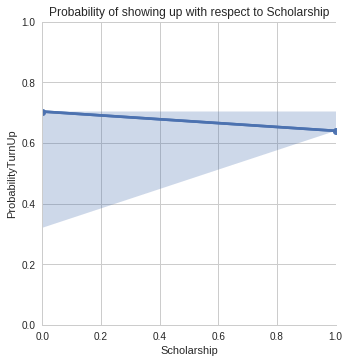

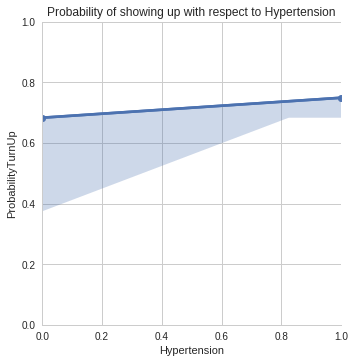

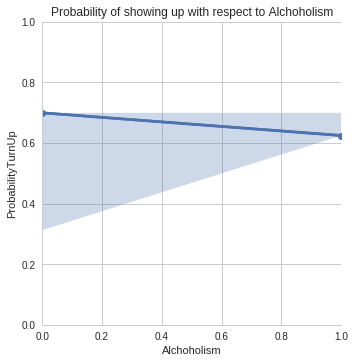

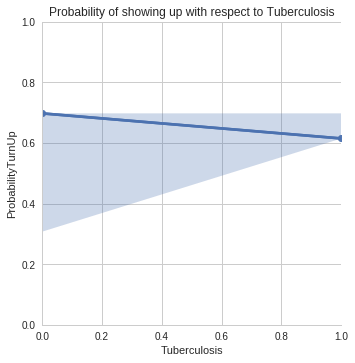

In [33]:
def prob_calc(data, variable):
    df = pds.crosstab(index = data[variable], columns = data.Status).reset_index()
    # print(df) Number of show up depending on each value of the variable
    df['ProbabilityTurnUp'] = df[1] / (df[0] + df[1])
    return df[[variable, 'ProbabilityTurnUp']]

# Put each gradient in a list
def find_gradient(variable, p):
    xs = p.get_lines()[0].get_xdata()
    dx = xs[0] - xs[len(xs) - 1]
    ys = p.get_lines()[0].get_ydata()
    dy = ys[0] - ys[len(ys) - 1]
    gradient = dy / dx
    gradients.append((abs(gradient), variable))

# Linear regression when chaning only the passed variable
def plot_wrt_variable(data, variable):
    sns.set_style("whitegrid")
    newdata = prob_calc(data, variable)
    sns.lmplot(data = newdata, x = variable, y = 'ProbabilityTurnUp', fit_reg = True)
    # Find regression line gradient - rate of change of probability wrt variable
    p = sns.regplot(data = newdata, x = variable, y = 'ProbabilityTurnUp')
    find_gradient(variable, p)
    from_x = min(list(data[variable]))
    to_x = max(list(data[variable]))
    sns.plt.xlim(from_x, to_x)
    sns.plt.ylim(0.0, 1.0)
    sns.plt.title('Probability of showing up with respect to {}'.format(variable))

 
# Rate of change wrt to each variable assuming they are independent
gradients = []

feature_list = [
#'Status', Using status is like using the answer to find the answer
'AwaitingTime',
'Age',
'Month',
'HourOfTheDay',
'DayOfTheWeek',
'Gender',
'Sms_Reminder',
'Handicap',
'Smokes',
'Diabetes',
'Scholarship',
'Hypertension',
'Alchoholism',
'Tuberculosis'
]

# Get binary features that needs different charting
binary_feature_list = [
    'Gender',
    'Diabetes',
    'Alchoholism',
    'Hypertension',
    'Handicap',
    'Smokes',
    'Scholarship',
    'Tuberculosis',
    'Sms_Reminder',
]

# Use 80% for training, 20% for testing
total = 296400
train = int(0.8 * total)

# Training Data (select first 80% of rows)
features_train = data[feature_list].iloc[:train]
# Testing Data (select last 20% of rows)
features_test = data[feature_list].iloc[train:]

# Results (outputs) for testing set
testing_output_list = data.Status[train:]
# Results (outputs) for training set
training_output_list = data.Status[:train]

# Multinomial naive bayes classification
clf =  MultinomialNB().fit(features_train, training_output_list)
print('Accuracy: ', round(accuracy_score(testing_output_list, clf.predict(features_test)), 3) * 100, '%')

# Compute and display AUC
results = clf.predict_proba(features_test)

# Can be improved - too slow probably should make 1 predict_proba query with all the entries - too late time is running out we need a demo
def analyse_sms_impact(data, results):
    # Analyse top 10%
    n = int(0.1 * len(results))
    n = 500
    not_attend = [(results[i][0], i) for i in range(n)]
    # find indices of 10 least probable
    indices = [i for (v, i) in sorted(not_attend)]
    tot_change = 0
    num_tries = 0
    # find correspoinding entries in data
    for i in indices:
        entry = data[feature_list].iloc[i:i + 1]
    
        # for each if sms_remainder is 0
        if entry['Sms_Reminder'].tolist()[0] == 1:
            continue
        
        # set to one retry, record probability change
        before = clf.predict_proba(entry)
        entry.loc[entry['Sms_Reminder'] != 1, 'Sms_Reminder'] = 1
        after = clf.predict_proba(entry)
        tot_change += (after[0][1] - before[0][1])        
        num_tries += 1
    # find average change
    avg = tot_change / num_tries
    # print average change
    print('Sending an sms to the top 10% has a change of {} in probability of showing up'.format(avg))
    

analyse_sms_impact(data, results)
# Calculate AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(testing_output_list, [i[1] for i in results])
roc_auc = auc(fpr, tpr)
print('AUC: ', roc_auc)
plt.plot(fpr, tpr, 'ro')

# Plot how each variable independently affects the probability of showing up
for variable in feature_list:
    plot_wrt_variable(data, variable)

sns.plt.show()
plt.show()